# Euclid Q1: 1D spectra

## Learning Goals

By the end of this tutorial, you will:
- Understand the basic characteristics of Euclid Q1 SIR 1D spectra.
- What columns are available in the MER catalog.
- How to query with ADQL in the MER catalog.
- How to make a simple color-magnitude diagram with the data.

## Introduction

Euclid launched in July 2023 as a European Space Agency (ESA) mission with involvement by NASA.
The primary science goals of Euclid are to better understand the composition and evolution of the dark Universe.
The Euclid mission is providing space-based imaging and spectroscopy as well as supporting ground-based imaging to achieve these primary goals.
These data will be archived by multiple global repositories, including IRSA, where they will support transformational work in many areas of astrophysics.

Euclid Quick Release 1 (Q1) consists of consists of ~30 TB of imaging, spectroscopy, and catalogs covering four non-contiguous fields:
Euclid Deep Field North (22.9 sq deg), Euclid Deep Field Fornax (12.1 sq deg), Euclid Deep Field South (28.1 sq deg), and LDN1641.

Among the data products included in the Q1 release are the 1D spectra created by the SIR Processing Function.
This notebook provides an introduction to these SIR 1D spectra.
If you have questions about it, please contact the [IRSA helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html).

## Imports

```{important}
We rely on ``astroquery`` features that have been recently added, so please make sure you have version v0.4.10 or newer installed.
```

In [1]:
# Uncomment the next line to install dependencies if needed
# !pip install matplotlib astropy 'astroquery>=0.4.10'

In [2]:
import urllib

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import QTable
from astropy import units as u
from astropy.visualization import quantity_support

from astroquery.ipac.irsa import Irsa

## 1. Search for the spectrum of a specific galaxy

First, explore what Euclid catalogs are available. Note that we need to use the object ID for our targets to be able to download their spectrum.

Search for all tables in IRSA labeled as "euclid".

In [3]:
Irsa.list_catalogs(filter='euclid')

{'euclid.tileid_association_q1': 'Euclid Q1 TILEID to Observation ID Association Table',
 'euclid.objectid_spectrafile_association_q1': 'Euclid Q1 Object ID to Spectral File Association Table',
 'euclid.observation_euclid_q1': 'Euclid Q1 CAOM Observation Table',
 'euclid.plane_euclid_q1': 'Euclid Q1 CAOM Plane Table',
 'euclid.artifact_euclid_q1': 'Euclid Q1 CAOM Artifact Table',
 'euclid_q1_mer_catalogue': 'Euclid Q1 MER Catalog',
 'euclid_q1_mer_morphology': 'Euclid Q1 MER Morphology',
 'euclid_q1_mer_cutouts': 'Euclid Q1 MER Cutouts',
 'euclid_q1_phz_photo_z': 'Euclid Q1 PHZ Photo-z Catalog',
 'euclid_q1_phz_star_sed': 'Euclid Q1 PHZ Star SED Catalog',
 'euclid_q1_phz_galaxy_sed': 'Euclid Q1 PHZ Galaxy SED Catalog',
 'euclid_q1_phz_classification': 'Euclid Q1 PHZ Classification Catalog',
 'euclid_q1_phz_qso_physical_parameters': 'Euclid Q1 PHZ QSO Physical Parameters Catalog',
 'euclid_q1_phz_nir_physical_parameters': 'Euclid Q1 PHZ NIR Physical Parameters Catalog',
 'euclid_q1_phz_

In [4]:
table_1dspectra = 'euclid.objectid_spectrafile_association_q1'

## 2. Search for the spectrum of a specific galaxy in the 1D spectra table

In [5]:
obj_id = 2689918641685825137

We will use TAP and an ASQL query to find the spectral data for our galaxy. (ADQL is the [IVOA Astronomical Data Query Language](https://www.ivoa.net/documents/latest/ADQL.html) and is based on SQL.)

In [6]:
adql_object = f"SELECT * FROM {table_1dspectra} WHERE objectid = {obj_id}"

# Pull the data on this particular galaxy
result = Irsa.query_tap(adql_object).to_table()

Pull out the file name from the ``result`` table:

In [7]:
file_uri = urllib.parse.urljoin(Irsa.tap_url, result['uri'][0])
file_uri

'https://irsa.ipac.caltech.edu/ibe/data/euclid/q1/SIR/102160608/EUC_SIR_W-COMBSPEC_102160608_2024-11-05T16:42:00.741819Z.fits'

## 3. Read in the spectrum for only our specific object

Currently IRSA has the spectra stored in very large files containing multiple (14220) extensions with spectra of many targets within one tile. You can choose to read in the big file below to see what it looks like (takes a few mins to load) or skip this step and just read in the specific extension we want for the 1D spectra (recommended).

In [8]:
# hdul = fits.open(file_uri)
# hdul.info()

Open the large FITS file without loading it entirely into memory, pulling out just the extension we want for the 1D spectra of our object

In [9]:
with fits.open(file_uri) as hdul:
    spectrum = QTable.read(hdul[result['hdu'][0]], format='fits')

    spec_header = hdul[result['hdu'][0]].header

In [10]:
spectrum

WAVELENGTH,SIGNAL,MASK,QUALITY,VAR,NDITH
Angstrom,erg / (Angstrom s cm2),Number,Number,erg2 / (Angstrom2 s2 cm4),Number
float32,float32,float64,float32,float32,float64
11900.0,0.0,1.0,0.0,0.0,0.0
11913.400390625,0.0,1.0,0.0,0.0,0.0
11926.7998046875,0.0,1.0,0.0,0.0,0.0
11940.2001953125,-0.42825955152511597,64.0,0.924927830696106,0.05231768637895584,2.0
11953.599609375,-0.019433781504631042,66.0,0.8561765551567078,0.010498150251805782,2.0
11967.0,0.02915639616549015,64.0,0.8876305818557739,0.003435363294556737,4.0
11980.400390625,0.08275385200977325,80.0,0.0,0.0017151220235973597,4.0
11993.7998046875,0.018765779212117195,64.0,0.8546596765518188,0.0009618347976356745,4.0


In [11]:
spec_header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   22 / width of table in bytes                        
NAXIS2  =                  531 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    6 / number of fields in each row                   
TTYPE1  = 'WAVELENGTH'         / label for field   1                            
TFORM1  = '1E      '           / data format of field: 4-byte REAL              
TUNIT1  = 'Angstrom'           / physical unit of field                         
TTYPE2  = 'SIGNAL  '           / label for field   2                            
TFORM2  = '1E      '        

## 4. Plot the image of the extracted spectrum

```{tip}
As we use astropy.visualization's ``quantity_support``, matplotlib automatically picks up the axis units from the quantitites we plot.
```

In [12]:
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7f5f57e599d0>

```{note}
The 1D combined spectra table contains 6 columns, below are a few highlights:

- WAVELENGTH is in Angstroms by default
- SIGNAL is the flux and should be multiplied by the FSCALE factor in the header
- MASK values can be used to determine which flux bins to discard. MASK = odd and MASK >=64 means the flux bins not be used.
```

In [13]:
signal_scaled = spectrum['SIGNAL'] * spec_header['FSCALE']

We investigate the MASK column to see which flux bins are recommended to keep vs "Do Not Use"

Text(0.5, 1.0, 'Values of MASK by flux bin')

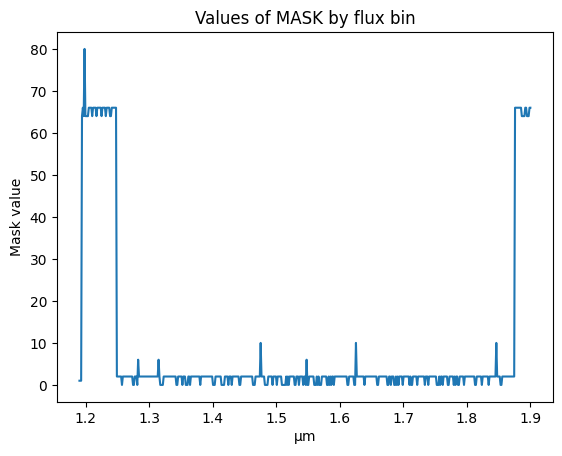

In [14]:
plt.plot(spectrum['WAVELENGTH'].to(u.micron), spectrum['MASK'])
plt.ylabel('Mask value')
plt.title('Values of MASK by flux bin')

We use the MASK column to create a boolean mask for values to ignore. We use the inverse of this mask to mark the flux bins to use.

Text(0.5, 1.0, 'Object ID 2689918641685825137')

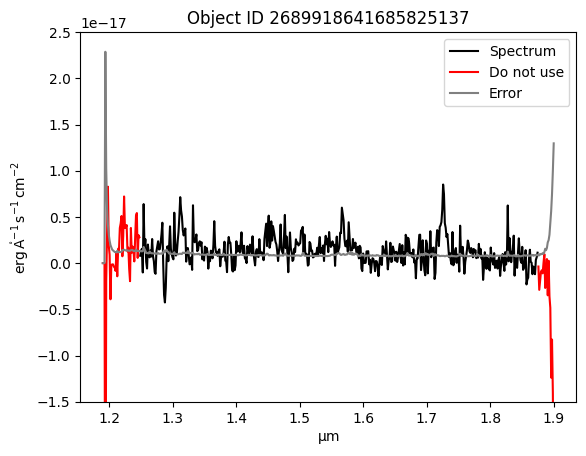

In [15]:
bad_mask = (spectrum['MASK'].value % 2 == 1) | (spectrum['MASK'].value >= 64)

plt.plot(spectrum['WAVELENGTH'].to(u.micron), np.ma.masked_where(bad_mask, signal_scaled), color='black', label='Spectrum')
plt.plot(spectrum['WAVELENGTH'], np.ma.masked_where(~bad_mask, signal_scaled), color='red', label='Do not use')
plt.plot(spectrum['WAVELENGTH'], np.sqrt(spectrum['VAR']) * spec_header['FSCALE'], color='grey', label='Error')

plt.legend(loc='upper right')
plt.ylim(-0.15E-16, 0.25E-16)
plt.title(f'Object ID {obj_id}')

## About this Notebook

**Author**: Tiffany Meshkat, Anahita Alavi, Anastasia Laity, Andreas Faisst, Brigitta Sipőcz, Dan Masters, Harry Teplitz, Jaladh Singhal, Shoubaneh Hemmati, Vandana Desai

**Updated**: 2025-03-31

**Contact:** [the IRSA Helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html) with questions or reporting problems.